In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cma_utils

In [11]:
def apply_pmd(E_in, DGD_ps_per_sqrt_km, L_m, N_sections, Rs, SpS):

    N_samples = E_in.shape[0]
    SD_tau = np.sqrt(3 * np.pi / 8) * DGD_ps_per_sqrt_km

    tau = (SD_tau * np.sqrt(L_m * 1e-3) / np.sqrt(N_sections)) * 1e-12

    tau_Ts = 2
    #tau=0
    # w = 2 * np.pi * np.fft.fftshift(np.linspace(-0.5, 0.5, N_samples)) * SpS * Rs
    w = 2 * np.pi * np.linspace(0, N_samples-1, N_samples) / N_samples

    E_V = np.fft.fft(E_in[:, 0])
    E_H = np.fft.fft(E_in[:, 1])

    for _ in range(N_sections):
        # Random complex coupling matrices (unitary)
        X = np.random.randn(2, 2) + 1j * np.random.randn(2, 2)
        U, _, Vh = np.linalg.svd(X)
        V = Vh.conj().T

        # # Rotate fields by U†
        # E1 = U[0, 0].conj() * E_V + U[0, 1].conj() * E_H
        # E2 = U[1, 0].conj() * E_V + U[1, 1].conj() * E_H
       
        # Apply differential delay
        E_V *= np.exp(1j * w * tau_Ts / 2)
        E_H *= np.exp(-1j * w * tau_Ts / 2)

        # # Rotate by V
        # E_V = V[0, 0] * E1 + V[0, 1] * E2
        # E_H = V[1, 0] * E1 + V[1, 1] * E2
      
    E_out_x = np.fft.ifft(E_V)
    E_out_y = np.fft.ifft(E_H)

    return np.column_stack((E_out_x, E_out_y))


In [18]:
N_symbols = 100000
levels = np.array([-1, 1]) / np.sqrt(2)
qam_symbols_x = (np.random.choice(levels, N_symbols) +
               1j * np.random.choice(levels, N_symbols))
qam_symbols_y = (np.random.choice(levels, N_symbols) +
               1j * np.random.choice(levels, N_symbols))

E_in = np.column_stack((qam_symbols_x, qam_symbols_y))  # shape (100, 2)

# check parameters with deepa ma'am
num_taps = 3

E_after_pmd = cma_utils.apply_pmd( 
E_in=E_in, 
# DGD_ps_per_sqrt_km=31.6, # typical mean DGD 
DGD_ps_per_sqrt_km=19.764,
L_m=10000, # fiber length
N_sections=1, # number of fiber sections 
Rs=32e9, # 32 gbaud
SpS=2 # samples per symbol 
)

print("Input shape:", E_in.shape)
print(E_in)
print("Output shape:", E_after_pmd.shape)
print(E_after_pmd)
#cma_utils.plot_constellation(E_in)
#cma_utils.plot_constellation(E_after_pmd)


tau_Ts 2.1707779111583436
Input shape: (100000, 2)
[[ 0.70710678+0.70710678j -0.70710678-0.70710678j]
 [-0.70710678-0.70710678j  0.70710678-0.70710678j]
 [ 0.70710678-0.70710678j  0.70710678+0.70710678j]
 ...
 [ 0.70710678-0.70710678j -0.70710678+0.70710678j]
 [-0.70710678+0.70710678j -0.70710678+0.70710678j]
 [-0.70710678+0.70710678j  0.70710678-0.70710678j]]
Output shape: (100000, 2)
[[-0.73644526-0.32364077j -1.07298485+0.45986291j]
 [-0.84178506-0.38486016j  0.74498277-0.27831216j]
 [-0.03287485-0.41632562j -1.04849751-0.7880678j ]
 ...
 [-0.06287075-1.30719772j  0.05819337+0.71703577j]
 [-0.43023329+1.14890982j -0.56632171-0.5097562j ]
 [ 0.21368249+0.04118031j -0.0010968 +1.51579441j]]


In [19]:
E_out, stats = cma_utils.vmcma_python(E_after_pmd, num_taps,mu_CMA=0.5e-4)
pxx, pxy, pyx, pyy, cma_error, conv_symbol = stats['pxx'], stats['pyx'], stats['pyx'], stats['pyy'], stats['cma_error'], stats['convergence_symbol']

In [20]:
print(cma_error[99999], cma_error[99998], conv_symbol)

0.3037771670891181 0.27603772399202675 None


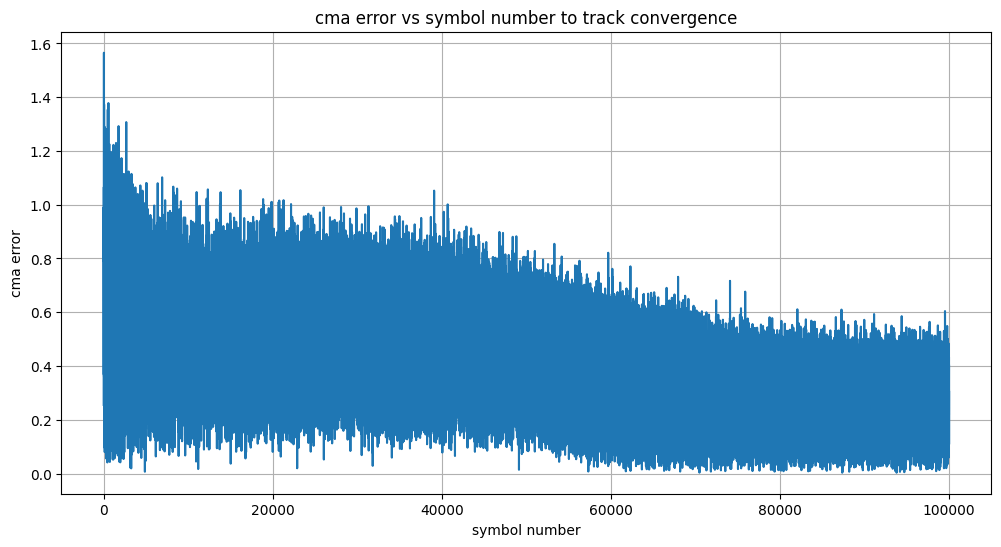

In [21]:
plt.figure(figsize=(12, 6)) 
plt.plot(list(cma_error.keys()), list(cma_error.values()))
plt.xlabel("symbol number")
plt.ylabel("cma error")
plt.title("cma error vs symbol number to track convergence")
plt.grid(True)
plt.show()

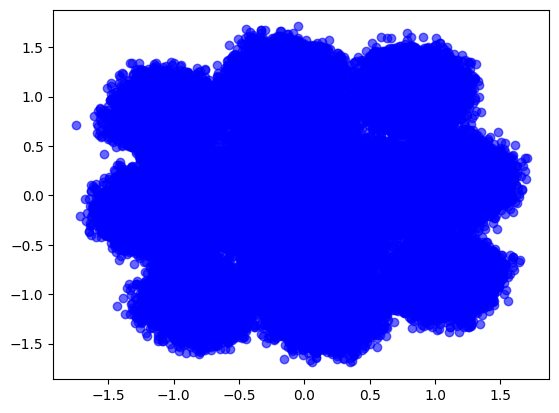

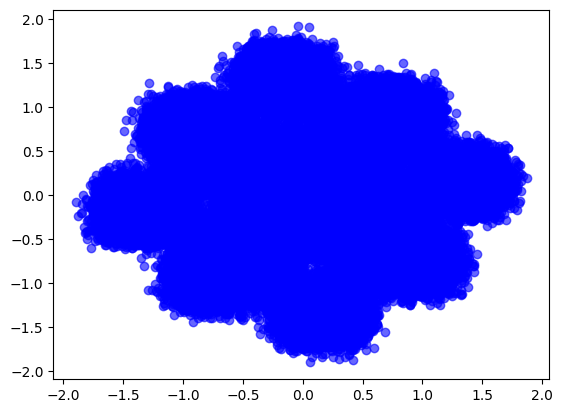

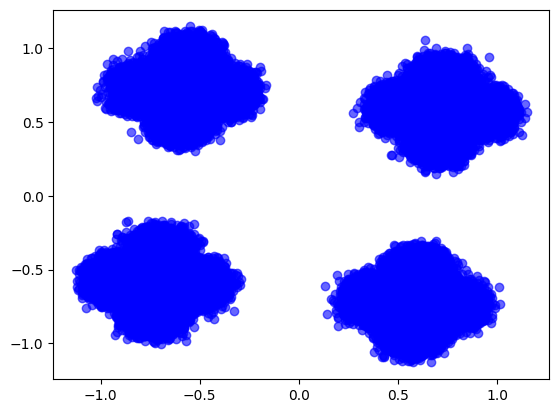

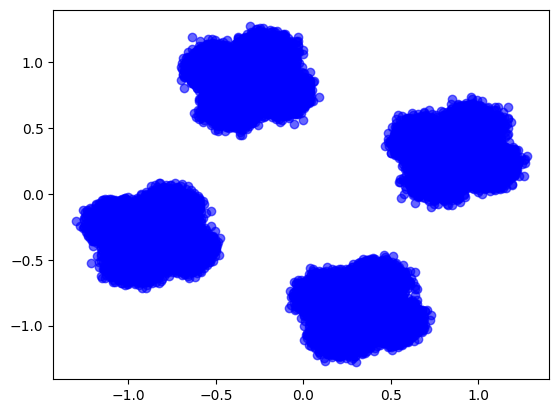

In [22]:
cma_utils.plot_constellation(E_after_pmd)
cma_utils.plot_constellation(E_out)